In [1]:
import os,sys,glob,time
smodelsPath = os.path.expanduser('~/smodels')
sys.path.append(smodelsPath)
from smodels.theory.auxiliaryFunctions import rescaleWidth, unscaleWidth
import numpy as np
from trimRegularGrid import trim1D, testTrimmedGrid, removeWidth, trimGrid
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.spatial import ConvexHull,Delaunay
from scipy.interpolate import griddata
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
maxDiff=5e-2
minValue=1e-8
ds = SR = 'SR2FULL_150'
tx = 'THSCPM1b'

ntries = 1
gridSize = []
maxError = []
dataFile = '%s_eff_mutrig_%s.dat' %(tx,ds)
valueLabel = ds
#Get data
data = np.genfromtxt(dataFile,names=True)
if 'width' in data.dtype.names:
    data['width'] = np.array([rescaleWidth(w) for w in data['width']])

#Pre-select data:
data = data[(data['width'] < 40) & (data['mhscp'] < 200)]
data = data[(data['width'] > 20)]

In [3]:
xy = np.array([list(x) for x in data[['mhscp','width']]])
yvals = data[SR]

In [4]:
def trimGridTest(points,values,minY = 1e-2,maxDiff = 5e-2,random=True):

    t0 = time.time()

    #Replace all small values by zero:
    values = np.where(values > minY,values,0.0)
    #Get triangulation:
    tri = Delaunay(points)
    #Get convex hull
    cHullvertices = list(set(tri.convex_hull.flatten()))
    #Get infor about neighbors:
    indptr,indices = tri.vertex_neighbor_vertices

    indexKeep = set([])
    indexRemove = set([])

    #If random = True, randomly walk through the grid:
    if random:
        indexList = np.random.permutation(len(tri.points))
    else:
        indexList = np.arange(len(tri.points))
        
    #First let's identify all points which could be individually removed:
    for counter,i in enumerate(indexList):
        if i in cHullvertices:
            indexKeep.add(i)
            continue #Do not remove pts in the convexhull or of simplices which already had a point removed

        #Get the neighbors to the point
        neighbors = indices[indptr[i]:indptr[i+1]]
        
        #Using a linear interpolator with neighbors check interpolation value at point i
        y_interp = griddata(tri.points[neighbors],values[neighbors],tri.points[i],method='linear')[0]
        y = values[i]

        if y < minY:
            diff = max(0,(y_interp-minY)/minY) #For values smaller than minY, just require y_interp < (1+maxDiff)*minY
        else:
            diff = abs(y_interp-y)/y #Relative difference

        if diff > maxDiff:
            keepPoint = True
        else:
            keepPoint = False
            
        if keepPoint:
            indexKeep.add(i)
        else:
            indexRemove.add(i)

    return list(indexKeep)


In [5]:
keepPts = trimGrid(xy,yvals,maxDiff=0.05,minY=1e-8,random=False)
removePts = [i for i in np.arange(len(xy)) if not i in keepPts]

Data successfully trimmed down to 79% (133/168) in 0.0 min


In [6]:
tri = Delaunay(xy)
cHullvertices = list(set(tri.convex_hull.flatten()))

In [15]:
newPts = xy[keepPts]
delPts = xy[removePts]
newVals = yvals[keepPts]
triNew = Delaunay(newPts)
cHullverticesNew = list(set(triNew.convex_hull.flatten()))
y_interp = griddata(newPts,newVals,tri.points)
diffs = np.where(yvals > minValue,np.abs(y_interp-yvals)/yvals,maxDiff*y_interp/minValue)
print('max diff=',diffs.max())

max diff= 0.03610230910495379


<ipython-input-15-f668a48ee7fc>:7: RuntimeWarning: divide by zero encountered in true_divide
  diffs = np.where(yvals > minValue,np.abs(y_interp-yvals)/yvals,maxDiff*y_interp/minValue)
<ipython-input-15-f668a48ee7fc>:7: RuntimeWarning: invalid value encountered in true_divide
  diffs = np.where(yvals > minValue,np.abs(y_interp-yvals)/yvals,maxDiff*y_interp/minValue)


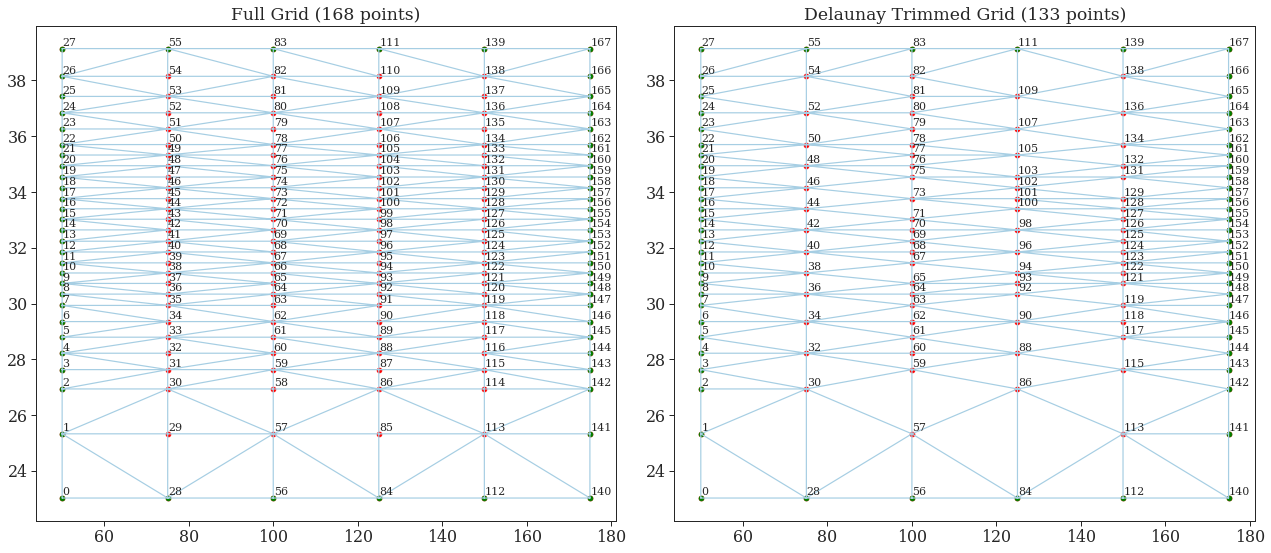

In [8]:
fig,ax = plt.subplots(ncols=2,figsize=(18,8))

ax[0].triplot(tri.points[:,0], tri.points[:,1], tri.simplices.copy())
ax[0].scatter(tri.points[:,0],tri.points[:,1],color='red')
ax[0].scatter(tri.points[cHullvertices][:,0],tri.points[cHullvertices][:,1],color='green')
for i,pt in enumerate(tri.points):
    ax[0].annotate('%i'%i,(pt[0]+0.1,pt[1]+0.1), fontsize=11)
# ax[0].set_xlim(50,90)
# ax[0].set_ylim(30,36)
ax[0].set_title('Full Grid (%i points)' %len(xy))    


ax[1].triplot(triNew.points[:,0], triNew.points[:,1], triNew.simplices.copy())
ax[1].scatter(triNew.points[:,0],triNew.points[:,1],color='red')
# ax[1].scatter(delPts[:,0],delPts[:,1],color='orange')
ax[1].scatter(triNew.points[cHullverticesNew][:,0],triNew.points[cHullverticesNew][:,1],color='green')
for i in keepPts:
    ax[1].annotate('%i'%i,(tri.points[i][0]+0.1,tri.points[i][1]+0.1), fontsize=11)
# for i,pt in enumerate(tri.points):    
#     ax[1].annotate('%1.2f'%y_interp[i],(1.02*tri.points[i][0],tri.points[i][1]-0.02), fontsize=10)    
# ax[1].set_xlim(50,90)
# ax[1].set_ylim(30,36)
ax[1].set_title('Delaunay Trimmed Grid (%i points)' %len(newPts))    

plt.tight_layout()
plt.show()

In [9]:
zlabel = 'width'
zpts = data[zlabel]
xlabels = [x for x in data.dtype.names if not 'ctau' in x.lower() and not x == valueLabel and not x == zlabel]
xpts = [list(x) for x in data[xlabels]]
ypts = data[valueLabel]
keepLines = trim1D(zpts,xpts,ypts,maxDiff=maxDiff,minY=minValue)

Data successfully trimmed down to 21% (36/168) in 0.0 min


In [14]:
newPts2 = xy[keepLines]
newVals2 = yvals[keepLines]
triNew2 = Delaunay(newPts2)
cHullverticesNew2 = list(set(triNew2.convex_hull.flatten()))
y_interp2 = griddata(newPts2,newVals2,tri.points)
diffs2 = np.where(yvals > minValue,np.abs(y_interp2-yvals)/yvals,maxDiff*y_interp2/minValue)
print('max diff=',diffs2.max())

max diff= 0.04513386998892316


<ipython-input-14-4181d176c117>:6: RuntimeWarning: invalid value encountered in true_divide
  diffs2 = np.where(yvals > minValue,np.abs(y_interp2-yvals)/yvals,maxDiff*y_interp2/minValue)


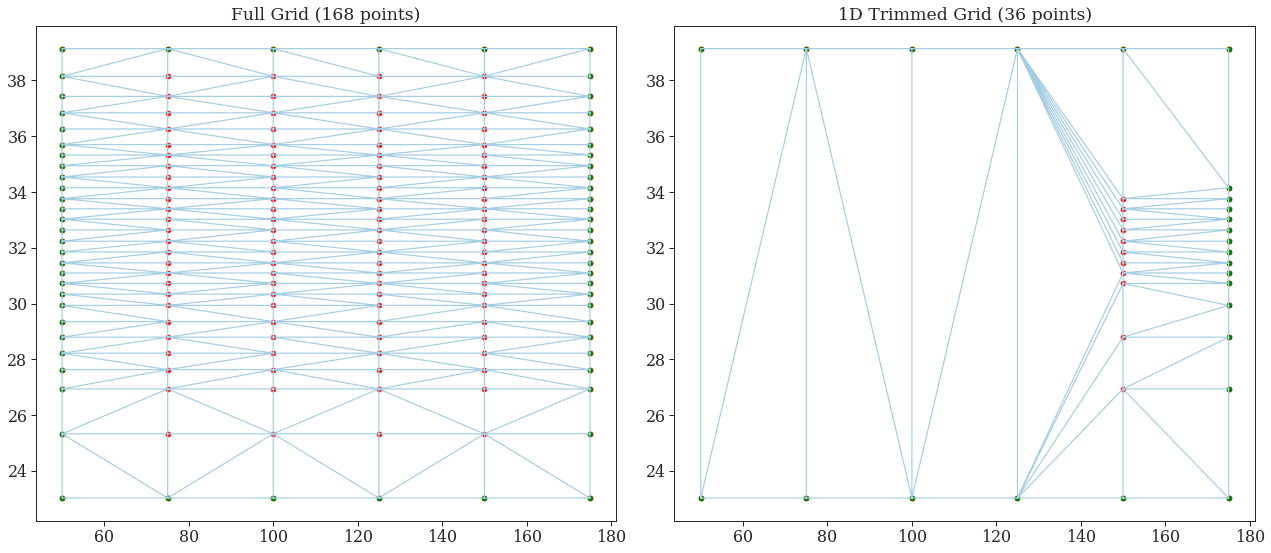

In [11]:
fig,ax = plt.subplots(ncols=2,figsize=(18,8))

ax[0].triplot(tri.points[:,0], tri.points[:,1], tri.simplices.copy())
ax[0].scatter(tri.points[:,0],tri.points[:,1],color='red')
ax[0].scatter(tri.points[cHullvertices][:,0],tri.points[cHullvertices][:,1],color='green')
# for i,pt in enumerate(xy):
#     ax[0].annotate('%i'%i,(1.02*pt[0],1.02*pt[1]), fontsize=12)
#     ax[0].annotate('%1.2f'%yvals[i],(1.02*pt[0],pt[1]-0.02), fontsize=10)
    
ax[0].set_title('Full Grid (%i points)' %len(xy))    


ax[1].triplot(triNew2.points[:,0], triNew2.points[:,1], triNew2.simplices.copy())
ax[1].scatter(triNew2.points[:,0],triNew2.points[:,1],color='red')
ax[1].scatter(triNew2.points[cHullverticesNew2][:,0],triNew2.points[cHullverticesNew2][:,1],color='green')
# for i in keepPts:
#     ax[1].annotate('%i'%i,(1.02*tri.points[i][0],1.02*tri.points[i][1]), fontsize=12)
# for i,pt in enumerate(tri.points):    
#     ax[1].annotate('%1.2f'%y_interp[i],(1.02*tri.points[i][0],tri.points[i][1]-0.02), fontsize=10)    

ax[1].set_title('1D Trimmed Grid (%i points)' %len(newPts2))    

plt.tight_layout()
plt.show()

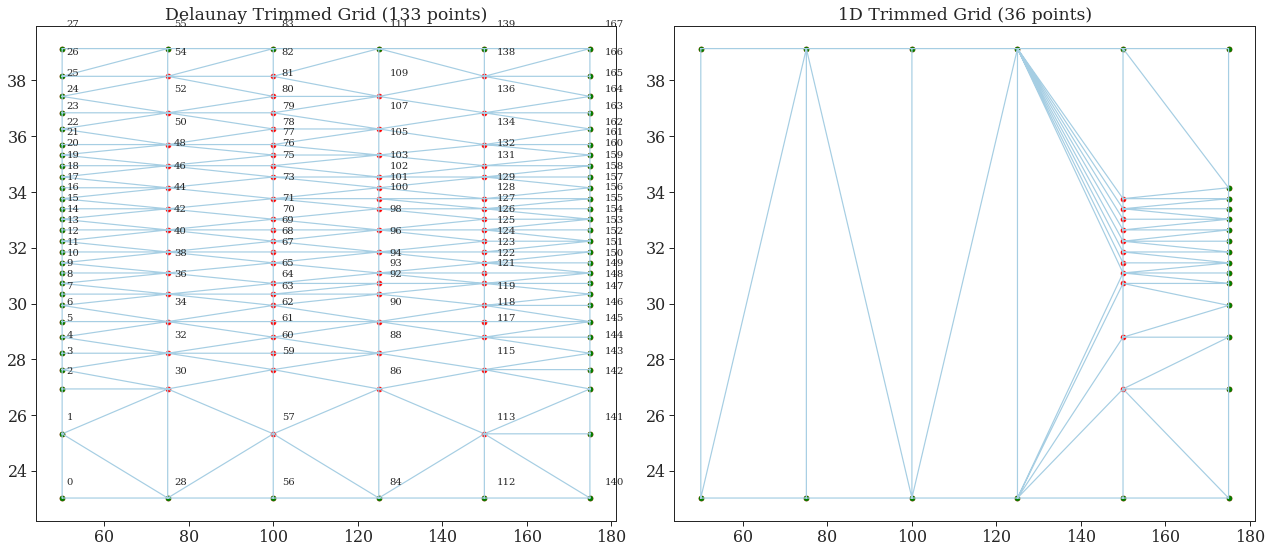

In [12]:
fig,ax = plt.subplots(ncols=2,figsize=(18,8))



ax[0].triplot(triNew.points[:,0], triNew.points[:,1], triNew.simplices.copy())
ax[0].scatter(triNew.points[:,0],triNew.points[:,1],color='red')
ax[0].scatter(triNew.points[cHullverticesNew][:,0],triNew.points[cHullverticesNew][:,1],color='green')
for i in keepPts:
    ax[0].annotate('%i'%i,(1.02*tri.points[i][0],1.02*tri.points[i][1]), fontsize=10)

ax[0].set_title('Delaunay Trimmed Grid (%i points)' %len(newPts))    



ax[1].triplot(triNew2.points[:,0], triNew2.points[:,1], triNew2.simplices.copy())
ax[1].scatter(triNew2.points[:,0],triNew2.points[:,1],color='red')
ax[1].scatter(triNew2.points[cHullverticesNew2][:,0],triNew2.points[cHullverticesNew2][:,1],color='green')
ax[1].set_title('1D Trimmed Grid (%i points)' %len(newPts2))    

plt.tight_layout()
plt.show()